In [1]:
%load_ext autoreload
%autoreload 2

In [216]:
import pandas as pd
import numpy as np
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from eval_utils import *
from plot_utils import *
sns.set_style('whitegrid')

In [3]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'

#### Quantitative analysis of confounding/selection bias

In [614]:
def average_of_perturbation_centroids(adata):
    pert_means = []
    pert_adata = adata[adata.obs['control'] == 0]
    for cond in pert_adata.obs['condition'].unique():
        adata_cond = pert_adata[pert_adata.obs['condition'] == cond]
        pert_mean = np.array(adata_cond.X.mean(axis=0))[0]
        pert_means.append(pert_mean)
    pert_means = np.array(pert_means)
    return np.mean(pert_means, axis=0)

def calculate_norms(pert_shifts):
    return np.linalg.norm(pert_shifts, axis=1)

def compute_shift_similarities(adata, avg_pert_centroids=True):
    pert_adata = adata[adata.obs['control'] == 0]
    control_adata = adata[adata.obs['control'] == 1]
    control_mean = np.array(control_adata.X.mean(axis=0))[0]
    
    if avg_pert_centroids:
        pert_mean = average_of_perturbation_centroids(pert_adata)
    else:
        pert_mean = np.array(pert_adata.X.mean(axis=0))[0]
    avg_shift = pert_mean-control_mean
    
    pert_shifts = {
        'avg_ctl': get_perturbation_shifts(adata, reference=control_mean),
        'avg_pert': get_perturbation_shifts(adata, reference=pert_mean)
    }

    pert_names = []
    similarities = {}
    pairwise_similarities = {}
    norms = {}
    for k, (perts, v) in pert_shifts.items():
        similarities[k] = calculate_cosine_similarities(v, avg_shift)
        pairwise_similarities[k] = calculate_pairwise_cosine_similarities(v)
        norms[k] = calculate_norms(v)
        pert_names.extend(perts)
    
    df = pd.DataFrame(similarities).melt()
    df_pair = pd.DataFrame(pairwise_similarities).melt()
    df_norm = pd.DataFrame(norms).melt()
    df['pert_names'] = pert_names
    df_norm['pert_names'] = pert_names
    
    return df, df_pair, df_norm, pert_names

In [615]:
seed = 1
datasets = ['Adamson2016', 'Norman2019', 'Replogle_rpe1_2022', 'Replogle_k562_2022']  #  'Dixit2016', 
dfs = []
dfs_pair = []
dfs_norm = []
for dataset in tqdm(datasets):
    file = f'../data/{dataset.lower()}/{dataset.lower()}_{seed}.h5ad'
    adata = anndata.read_h5ad(file)
    df, df_pair, df_norm, pert_names = compute_shift_similarities(adata)
    df['dataset'] = dataset
    df_pair['dataset'] = dataset
    df_norm['dataset'] = dataset
    dfs.append(df)
    dfs_pair.append(df_pair)
    dfs_norm.append(df_norm)
dfs = pd.concat(dfs)
dfs_pair = pd.concat(dfs_pair)
dfs_norm = pd.concat(dfs_norm)

100%|████████████████████████████████████████████| 4/4 [01:52<00:00, 28.16s/it]


In [344]:
grouped_vals = dfs[dfs['variable'] == 'avg_ctl'].groupby('dataset')['value']
grouped_vals.mean(), grouped_vals.std()

(dataset
 Adamson2016           0.761952
 Dixit2016             0.264402
 Norman2019            0.503184
 Replogle_k562_2022    0.377691
 Replogle_rpe1_2022    0.628735
 Name: value, dtype: float32,
 dataset
 Adamson2016           0.305866
 Dixit2016             0.391523
 Norman2019            0.255353
 Replogle_k562_2022    0.175251
 Replogle_rpe1_2022    0.269393
 Name: value, dtype: float32)

In [616]:
grouped_vals = dfs[dfs['variable'] == 'avg_ctl'].groupby('dataset')['value']
grouped_vals.mean(), grouped_vals.std()

(dataset
 Adamson2016           0.762213
 Norman2019            0.502577
 Replogle_k562_2022    0.378542
 Replogle_rpe1_2022    0.628873
 Name: value, dtype: float32,
 dataset
 Adamson2016           0.302790
 Norman2019            0.260037
 Replogle_k562_2022    0.173393
 Replogle_rpe1_2022    0.272817
 Name: value, dtype: float32)

In [345]:
grouped_vals = dfs[dfs['variable'] == 'avg_pert'].groupby('dataset')['value']
grouped_vals.mean(), grouped_vals.std()

(dataset
 Adamson2016           0.041150
 Dixit2016             0.000259
 Norman2019           -0.025846
 Replogle_k562_2022   -0.113240
 Replogle_rpe1_2022    0.154338
 Name: value, dtype: float32,
 dataset
 Adamson2016           0.232938
 Dixit2016             0.497685
 Norman2019            0.443471
 Replogle_k562_2022    0.312788
 Replogle_rpe1_2022    0.512144
 Name: value, dtype: float32)

In [620]:
grouped_vals = dfs[dfs['variable'] == 'avg_pert'].groupby('dataset')['value']
grouped_vals.mean(), grouped_vals.std()

(dataset
 Adamson2016           0.046049
 Norman2019           -0.115331
 Replogle_k562_2022   -0.076749
 Replogle_rpe1_2022   -0.062717
 Name: value, dtype: float32,
 dataset
 Adamson2016           0.231980
 Norman2019            0.450736
 Replogle_k562_2022    0.305861
 Replogle_rpe1_2022    0.528551
 Name: value, dtype: float32)

/tmp/ipykernel_1751219/3723816387.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Adamson (2016)',
/tmp/ipykernel_1751219/3723816387.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Adamson (2016)',


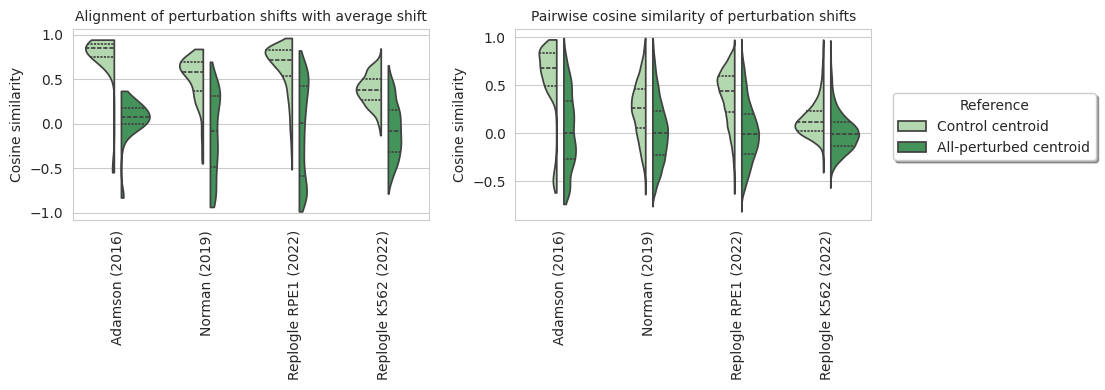

In [623]:
fig = plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)

sns.violinplot(data=dfs,
               x='dataset',
               y='value',
               hue='variable',
               split=True,
               inner="quart",
               gap=.2,
               ax=plt.gca(),
               palette="Greens",
               cut=0)
plt.legend([],[], frameon=False)
plt.title('Alignment of perturbation shifts with average shift', fontsize=10)
plt.ylabel('Cosine similarity')
plt.xlabel('')
plt.xticks(rotation=90)

# X ticks labels
plt.gca().set_xticklabels(['Adamson (2016)',
                           # 'Dixit (2016)',
                           'Norman (2019)',
                           'Replogle RPE1 (2022)',
                           'Replogle K562 (2022)',
                          ])

plt.subplot(1, 2, 2)
sns.violinplot(data=dfs_pair,
               x='dataset',
               y='value',
               hue='variable',
               split=True,
               inner="quart",
               gap=.2,
               ax=plt.gca(),
               palette="Greens",
               cut=0)
plt.legend([],[], frameon=False)
plt.title('Pairwise cosine similarity of perturbation shifts', fontsize=10)
plt.ylabel('Cosine similarity')
plt.xlabel('')
plt.xticks(rotation=90)

# X ticks labels
plt.gca().set_xticklabels(['Adamson (2016)',
                           # 'Dixit (2016)',
                           'Norman (2019)',
                           'Replogle RPE1 (2022)',
                           'Replogle K562 (2022)',
                          ])


# Legend
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles,
                    labels,
                    title='Reference',
                    loc='lower center',
                    bbox_to_anchor=(1.12, 0.57),
                    fancybox=True,
                    shadow=True,
                    ncol=1,
                    # title_fontproperties={'weight':'bold'}
                   )
labels=['Control centroid', 'All-perturbed centroid']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label);
plt.tight_layout();
plt.savefig(f'{figdir}/perturbation_shifts_combined_similarities_3.pdf', bbox_inches='tight');

In [2]:
fig = plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)

sns.violinplot(data=dfs,
               x='dataset',
               y='value',
               hue='variable',
               split=True,
               inner="quart",
               gap=.2,
               ax=plt.gca(),
               palette="Greens",
               cut=0)
plt.legend([],[], frameon=False)
plt.title('Alignment of perturbation shifts with average shift', fontsize=10)
plt.ylabel('Cosine similarity')
plt.xlabel('')
plt.xticks(rotation=90)

# X ticks labels
plt.gca().set_xticklabels(['Adamson (2016)',
                           # 'Dixit (2016)',
                           'Norman (2019)',
                           'Replogle RPE1 (2022)',
                           'Replogle K562 (2022)',
                          ])

plt.subplot(1, 2, 2)
sns.violinplot(data=dfs_pair,
               x='dataset',
               y='value',
               hue='variable',
               split=True,
               inner="quart",
               gap=.2,
               ax=plt.gca(),
               palette="Greens",
               cut=0)
plt.legend([],[], frameon=False)
plt.title('Pairwise cosine similarity of perturbation shifts', fontsize=10)
plt.ylabel('Cosine similarity')
plt.xlabel('')
plt.xticks(rotation=90)

# X ticks labels
plt.gca().set_xticklabels(['Adamson (2016)',
                           # 'Dixit (2016)',
                           'Norman (2019)',
                           'Replogle RPE1 (2022)',
                           'Replogle K562 (2022)',
                          ])


# Legend
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles,
                    labels,
                    title='Reference',
                    loc='lower center',
                    bbox_to_anchor=(1.12, 0.57),
                    fancybox=True,
                    shadow=True,
                    ncol=1,
                    # title_fontproperties={'weight':'bold'}
                   )
labels=['Control centroid', 'All-perturbed centroid']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label);
plt.tight_layout();
# plt.savefig(f'{figdir}/perturbation_shifts_combined_similarities_3.pdf', bbox_inches='tight');

NameError: name 'plt' is not defined

#### Norm and sensitivity analysis

/tmp/ipykernel_1751219/3073748019.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Adamson (2016)',


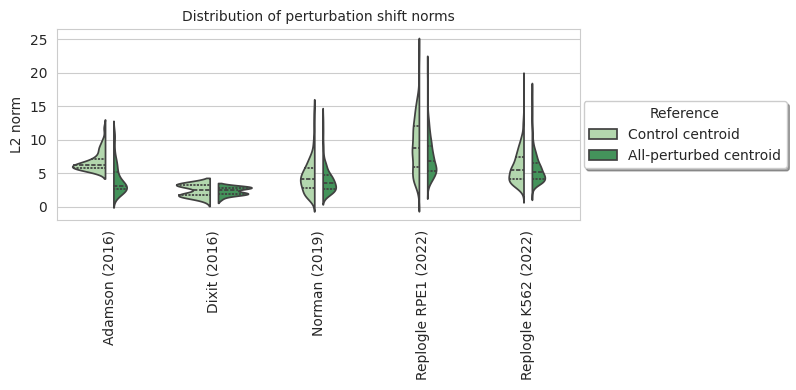

In [540]:
fig = plt.figure(figsize=(6, 4))

sns.violinplot(data=dfs_norm,
               x='dataset',
               y='value',
               hue='variable',
               split=True,
               inner="quart",
               gap=.2,
               ax=plt.gca(),
               palette="Greens")
plt.legend([],[], frameon=False)
plt.title('Distribution of perturbation shift norms', fontsize=10)
plt.ylabel('L2 norm')
plt.xlabel('')
plt.xticks(rotation=90)

# X ticks labels
plt.gca().set_xticklabels(['Adamson (2016)',
                           'Dixit (2016)',
                           'Norman (2019)',
                           'Replogle RPE1 (2022)',
                           'Replogle K562 (2022)',
                          ])


# Legend
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles,
                    labels,
                    title='Reference',
                    loc='lower center',
                    bbox_to_anchor=(1.15, 0.55),
                    fancybox=True,
                    shadow=True,
                    ncol=1,
                    # title_fontproperties={'weight':'bold'}
                   )
labels=['Control centroid', 'All-perturbed centroid']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label);
plt.tight_layout();
plt.savefig(f'{figdir}/perturbation_shifts_norms.pdf', bbox_inches='tight');

/tmp/ipykernel_1751219/1917979319.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['Adamson (2016)',


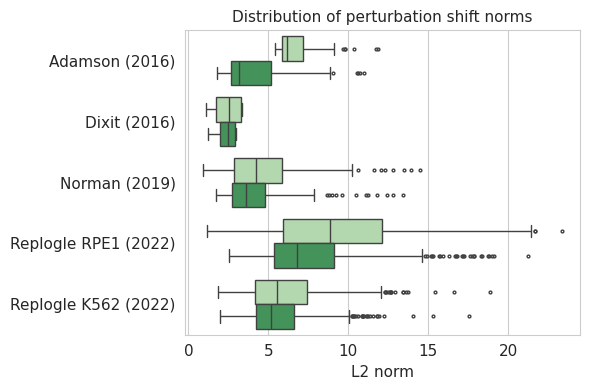

In [588]:
fig = plt.figure(figsize=(6, 4))
fontsize = 11
g = sns.boxplot(data=dfs_norm,
               y='dataset',
               x='value',
               hue='variable',
               # split=True,
               # inner="quart",
               # gap=.2,
               fliersize=2,
               ax=plt.gca(),
               palette="Greens")
g.tick_params(labelsize=fontsize)
plt.legend([],[], frameon=False)
plt.title('Distribution of perturbation shift norms', fontsize=fontsize)
plt.xlabel('L2 norm', fontsize=fontsize)
plt.ylabel('')
# plt.xticks(rotation=90)

# X ticks labels
plt.gca().set_yticklabels(['Adamson (2016)',
                           'Dixit (2016)',
                           'Norman (2019)',
                           'Replogle RPE1 (2022)',
                           'Replogle K562 (2022)',
                          ])

plt.tight_layout();
plt.savefig(f'{figdir}/perturbation_shifts_norms.pdf', bbox_inches='tight');

In [395]:
df_norm_norman = dfs_norm[dfs_norm['dataset'] == 'Norman2019']
# df_norm_norman[df_norm_norman['variable'] == 'avg_pert'].sort_values(by='value')
df_norm_norman[df_norm_norman['variable'] == 'avg_ctl'].sort_values(by='value')

,variable,value,pert_names,dataset
83,avg_ctl,0.920993,BCL2L11+ctrl,Norman2019
104,avg_ctl,1.056738,BAK1+ctrl,Norman2019
186,avg_ctl,1.241967,RUNX1T1+ctrl,Norman2019
148,avg_ctl,1.251460,ctrl+BAK1,Norman2019
144,avg_ctl,1.302115,ctrl+UBASH3A,Norman2019
...,...,...,...,...
154,avg_ctl,12.283138,ctrl+CEBPA,Norman2019
125,avg_ctl,12.789650,CEBPB+CEBPA,Norman2019
6,avg_ctl,13.512120,CEBPE+CEBPA,Norman2019
70,avg_ctl,13.905105,JUN+CEBPA,Norman2019


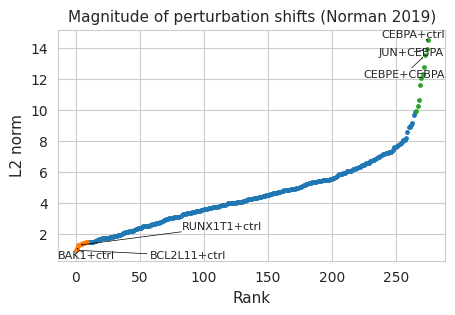

In [557]:
fontsize = 11

df_ = df_norm_norman[df_norm_norman['variable'] == 'avg_ctl'].sort_values(by='value')
x = np.arange(len(df_))
y = df_['value'].values

plt.figure(figsize=(5, 3))
plt.title('Magnitude of perturbation shifts (Norman 2019)', fontsize=fontsize)
plt.ylabel('L2 norm', fontsize=fontsize)
plt.xlabel('Rank', fontsize=fontsize)
s = 6
plt.scatter(x[topk:-topk], y[topk:-topk], s=s);
plt.scatter(x[:topk], y[:topk], s=s);
plt.scatter(x[-topk:], y[-topk:], s=s);

topk = 10
texts = []
gene_names = df_['pert_names'].values
n = len(gene_names)-1
for i in range(3):
    texts.append(plt.text(x[n-i], y[n-i], gene_names[n-i], fontsize=8))
    texts.append(plt.text(x[i], y[i], gene_names[i], fontsize=8))
# texts.append(plt.text(x[0], y[0], gene_names[0], fontsize=9))
# texts.append(plt.text(x[1], y[1], gene_names[1], fontsize=9))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=0.5),
            min_arrow_len=10,
            # only_move='x-',
            force_text=(1, 1),
            force_static=(1, 1)
           )
plt.savefig(f'{figdir}/perturbation_shifts_norman2019_scatter_norm.pdf', bbox_inches='tight');

In [398]:
file = f'../data/norman2019/norman2019_{seed}.h5ad'
adata = anndata.read_h5ad(file)
df, df_pair, df_norm, pert_names = compute_shift_similarities(adata)

In [516]:
topk = 10
adata_minus_strong = adata[~adata.obs['condition'].isin(gene_names[:topk])]
adata_minus_weak = adata[~adata.obs['condition'].isin(gene_names[-topk:])]
df_minus_strong, df_pair_minus_strong, df_norm_minus_strong, pert_names_minus_strong = compute_shift_similarities(adata_minus_strong)
df_minus_weak, df_pair_minus_weak, df_norm_minus_weak, pert_names_minus_weak = compute_shift_similarities(adata_minus_weak)

In [535]:
len(adata_minus_strong), len(adata_minus_weak), len(adata)

(85489, 87589, 89357)

In [530]:
df_minus_strong['type'] = 'Minus top 10 \n strong perturbations'
df_minus_weak['type'] = 'Minus top 10 \n weak perturbations'
df_pair_minus_strong['type'] = 'Minus top 10 \n strong perturbations'
df_pair_minus_weak['type'] = 'Minus top 10 \n weak perturbations'

dfs_2 = pd.concat([df_minus_weak, df_minus_strong])
dfs_pair_2 = pd.concat([df_pair_minus_weak, df_pair_minus_strong])

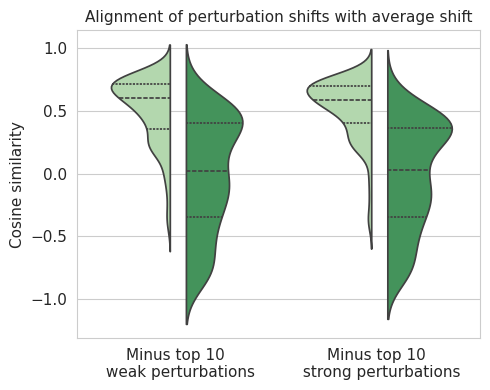

In [567]:
fig = plt.figure(figsize=(5, 4))

fontsize=11
g = sns.violinplot(data=dfs_2,
               x='type',
               y='value',
               hue='variable',
               split=True,
               inner="quart",
               gap=.2,
               ax=plt.gca(),
               palette="Greens")
g.tick_params(labelsize=fontsize)
plt.legend([],[], frameon=False)
plt.title('Alignment of perturbation shifts with average shift', fontsize=fontsize)
plt.ylabel('Cosine similarity', fontsize=fontsize)
plt.xlabel('');
# plt.xticks(rotation=90)

plt.tight_layout();
plt.savefig(f'{figdir}/perturbation_shifts_sensitivity_norman2019.pdf', bbox_inches='tight');

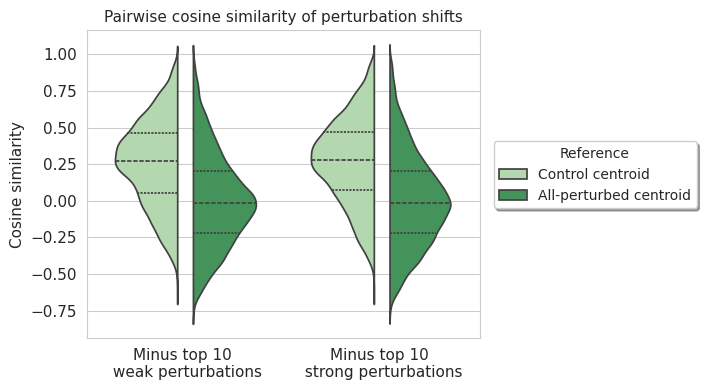

In [566]:
fig = plt.figure(figsize=(5, 4))
g = sns.violinplot(data=dfs_pair_2,
               x='type',
               y='value',
               hue='variable',
               split=True,
               inner="quart",
               gap=.2,
               ax=plt.gca(),
               palette="Greens")
g.tick_params(labelsize=fontsize)
plt.legend([],[], frameon=False)
plt.title('Pairwise cosine similarity of perturbation shifts', fontsize=fontsize)
plt.ylabel('Cosine similarity', fontsize=fontsize)
plt.xlabel('');
# plt.xticks(rotation=90)

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
legend = fig.legend(handles,
                    labels,
                    title='Reference',
                    loc='lower center',
                    bbox_to_anchor=(1.2, 0.45),
                    fancybox=True,
                    shadow=True,
                    ncol=1,
                    # title_fontproperties={'weight':'bold'}
                   )
labels=['Control centroid', 'All-perturbed centroid']
for i, label in enumerate(labels):
    legend.get_texts()[i].set_text(label);
plt.tight_layout();
plt.savefig(f'{figdir}/perturbation_shifts_pairwise_sensitivity_norman2019.pdf', bbox_inches='tight');